In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

In [2]:
from sklearn import metrics

In [3]:
from tensorflow import keras

In [4]:
from tensorflow.keras.optimizers import Adam

In [5]:
from sklearn.utils import shuffle

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [7]:
import sys

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
sys.path.append('../')

In [10]:
import datatools

In [11]:
import importlib

In [12]:
from glob import glob

In [13]:
SIM="/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/20220901/SIG_atlas_nsw_pad_z0_bkgr_1_BKG_stgBkg20_stgMaxBkgHit1/"
DATA_LOC=f"{SIM}/TRAIN/*.h5"

files=glob(DATA_LOC)

print(len(files))

200


In [14]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files, max_files=500, sort_by='z')

~~ Reading data... ~~


100%|██████████| 200/200 [01:37<00:00,  2.05it/s]


~~ Calculating occupancy information... ~~


100%|██████████| 500000/500000 [00:16<00:00, 30563.75it/s]

!!
I read 500000 events, of which 250000 have muon and 250000 do not
!!


In [15]:
this_cut=(Y_mu==1)

In [66]:
model_loc = '../models/'
model_name = "MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat"

In [17]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

linearized = True

In [18]:
if 'DetMat' in model_name:
    detmat=f"{SIM}/atlas_nsw_pad_z0.yml"
    X_prep = datatools.detector_matrix(dmat, sig_keys, detcard=detmat)
else:
    X_prep = datatools.training_prep(dmat, sig_keys)

~~ Preparing detector-based data matrix ~~
Using detector card: /gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/20220901/SIG_atlas_nsw_pad_z0_bkgr_1_BKG_stgBkg20_stgMaxBkgHit1//atlas_nsw_pad_z0.yml
[0, 5.1, 21.9, 27.0, 92.0, 103.5, 125.2, 125.2, 136.6, 136.6, 223.0, 223.0, 234.5, 234.5, 256.2, 267.6, 334.0, 339.1, 355.9, 361.0]


100%|██████████| 500000/500000 [01:41<00:00, 4945.93it/s]

Output data matrix shape: (500000, 20, 20)


In [21]:
import trainingvariables

In [22]:
vars_of_interest = np.zeros(X_prep.shape[2], dtype=bool)
training_vars = trainingvariables.tvars
for tv in training_vars:
    vars_of_interest[sig_keys.index(tv)] = 1

In [23]:
X = X_prep[:,:,vars_of_interest]
X_keys = np.array(sig_keys)[vars_of_interest]

In [24]:
mult_fact = max(data['ev_mu_x'])
mult_facta = max(data['ev_mu_theta'])

In [25]:
data_ev_mu_x = (data['ev_mu_x'])/mult_fact
data_ev_mu_a = (data['ev_mu_theta'])/mult_facta

X_train, Y_clas_train, Y_xreg_train, Y_areg_train = shuffle(X, Y_mu, data_ev_mu_x, data_ev_mu_a)

Y_train = np.zeros( (Y_clas_train.shape[0], 3 ) ) 
Y_train[:,0] = Y_clas_train
Y_train[:,1] = Y_xreg_train
Y_train[:,2] = Y_areg_train

In [67]:
keras_model = keras.models.load_model(model_loc+model_name,compile=False)

In [68]:
keras_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 20, 7)]           0         
_________________________________________________________________
C1D_1 (Conv1D)               (None, 18, 5)             110       
_________________________________________________________________
flatten (Flatten)            (None, 90)                0         
_________________________________________________________________
output (Dense)               (None, 3)                 273       
Total params: 383
Trainable params: 383
Non-trainable params: 0
_________________________________________________________________


In [69]:
all_weights = np.array([])
weights_and_labels_w = []
weights_and_labels_l = []
for layer in keras_model.layers:
    print(layer.name)
    for iw,w in enumerate(layer.weights):
        this_w_v = w.numpy().flatten()
        all_weights = np.concatenate( [this_w_v, all_weights] )
        print (layer.name, w.numpy().shape, np.max( np.abs(w.numpy().flatten()) ), np.min( np.abs(w.numpy().flatten())))
        if len(w.numpy().flatten()) > 0:
            this_w_v = np.abs(this_w_v)
            # this_w_v = this_w_v[this_w_v>0]
            this_w_v[ this_w_v < 2**-100] = 2**-100
            weights_and_labels_w.append( np.log2( this_w_v ) )
            weights_and_labels_l.append( layer.name + f'_{iw}' )

inputs
C1D_1
C1D_1 (3, 7, 5) 0.99887514 0.0063583497
C1D_1 (5,) 1.6391817 0.055286985
flatten
output
output (90, 3) 0.44780362 4.4684206e-05
output (3,) 0.48170903 0.048593372


In [70]:
len(weights_and_labels_w)

4

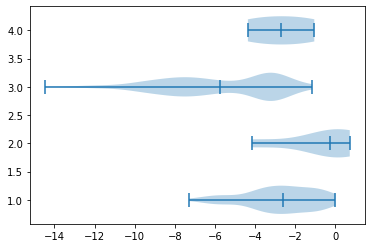

In [71]:
plt.Figure()
plt.violinplot(weights_and_labels_w, vert=False, showmedians=True)
plt.show()

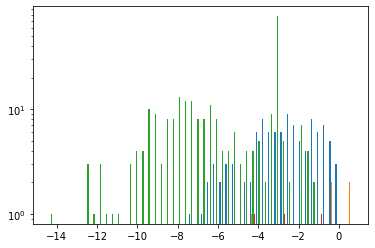

In [72]:
plt.Figure()
plt.hist( weights_and_labels_w, bins=50 )
plt.yscale('log')
plt.show()

In [73]:
keras_model.layers[1].weights[1].numpy().flatten()

array([ 0.8269721 , -0.77404016,  0.05528698,  1.4037338 ,  1.6391817 ],
      dtype=float32)

In [74]:
keras_preds = keras_model.predict(X, batch_size=1024)

In [75]:
keras_yhat = sigmoid(keras_preds[:,0])

In [76]:
keras_x_reg = keras_preds[:,1]*mult_fact
keras_a_reg = keras_preds[:,2]*mult_facta

In [77]:
keras_mod_msex = metrics.mean_squared_error(  data['ev_mu_x'][this_cut], keras_x_reg[this_cut] )
keras_mod_msea = metrics.mean_squared_error( data['ev_mu_theta'][this_cut], keras_a_reg[this_cut] )
keras_mod_auc = metrics.roc_auc_score( Y_mu, keras_yhat )
keras_fpr, keras_tpr, keras_thresholds = metrics.roc_curve( Y_mu, keras_yhat )
print(keras_mod_msex, keras_mod_msea, keras_mod_auc)

1.8473357596306503 3.0480629982369585e-05 0.9580532305839999


## Pruning

In [78]:
import tensorflow_model_optimization as tfmot

In [79]:
# Compute end step to finish pruning after 2 epochs.
batch_size = 128**4
epochs = 2
validation_split = 0.1 # 10% of training set will be used for validation set. 

In [80]:
num_images = X.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

In [81]:
import mlmodels

In [82]:
import tempfile

In [83]:
initial_sparsities = [0]
final_sparsities = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
# final_sparsities = [1, 5, 10, 50, 100, 500]
pruned_mod_msex_s = []
pruned_mod_msea_s = []
pruned_mod_auc_s = []

/opt/conda/envs/rapids/lib/python3.8/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.5144 - val_loss: 0.5425
Epoch 2/50
1/1 [==============================] - 0s 379ms/step - loss: 0.5771 - val_loss: 0.5403
Epoch 3/50
1/1 [==============================] - 0s 269ms/step - loss: 0.5785 - val_loss: 0.5247
Epoch 4/50
1/1 [==============================] - 0s 275ms/step - loss: 0.5569 - val_loss: 0.4905
Epoch 5/50
1/1 [==============================] - 0s 274ms/step - loss: 0.5231 - val_loss: 0.5159
Epoch 6/50
1/1 [==============================] - 0s 270ms/step - loss: 0.5506 - val_loss: 0.5058
Epoch 7/50
1/1 [==============================] - 0s 285ms/step - loss: 0.5305 - val_loss: 0.4860
Epoch 8/50
1/1 [==============================] - 0s 279ms/step - loss: 0.5024 - val_loss: 0.4936
Epoch 9/50
1/1 [==============================] - 0s 271ms/step - loss: 0.5236 - val_loss: 0.4879
Epoch 10/50
1/1 [==============================] - 0s 275ms/step - loss: 0.5144 - val_loss: 0.4866
Epoch 11/50
1/1 [=====

<ipython-input-84-5e975b39d3a8>:91: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-84-5e975b39d3a8>:92: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( ttpr, 1./tfpr, color='red' )


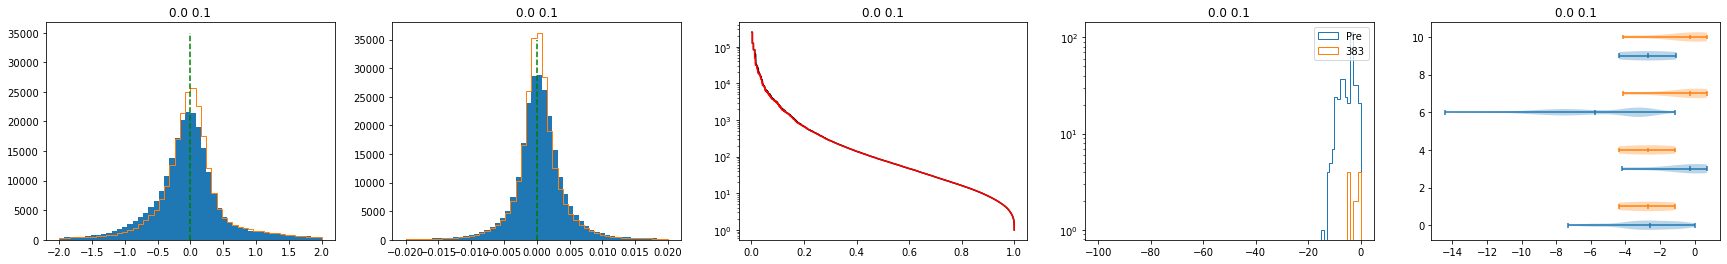

/opt/conda/envs/rapids/lib/python3.8/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.4892 - val_loss: 0.6304
Epoch 2/50
1/1 [==============================] - 0s 340ms/step - loss: 0.7092 - val_loss: 0.5198
Epoch 3/50
1/1 [==============================] - 0s 272ms/step - loss: 0.5547 - val_loss: 0.5569
Epoch 4/50
1/1 [==============================] - 0s 269ms/step - loss: 0.5891 - val_loss: 0.5648
Epoch 5/50
1/1 [==============================] - 0s 272ms/step - loss: 0.5991 - val_loss: 0.5091
Epoch 6/50
1/1 [==============================] - 0s 269ms/step - loss: 0.5338 - val_loss: 0.4945
Epoch 7/50
1/1 [==============================] - 0s 274ms/step - loss: 0.5244 - val_loss: 0.5242
Epoch 8/50
1/1 [==============================] - 0s 271ms/step - loss: 0.5621 - val_loss: 0.5130
Epoch 9/50
1/1 [==============================] - 0s 269ms/step - loss: 0.5416 - val_loss: 0.4854
Epoch 10/50
1/1 [==============================] - 0s 273ms/step - loss: 0.4980 - val_loss: 0.4969
Epoch 11/50
1/1 [=====

<ipython-input-84-5e975b39d3a8>:91: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-84-5e975b39d3a8>:92: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( ttpr, 1./tfpr, color='red' )


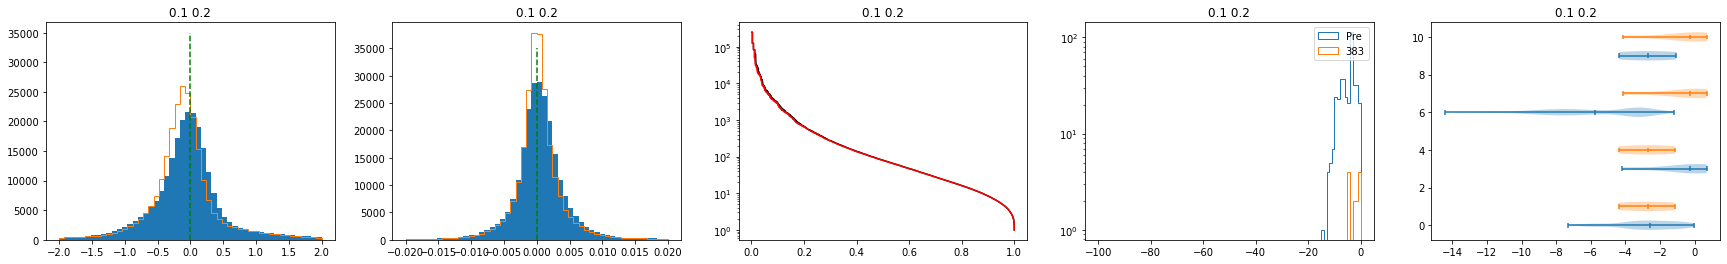

/opt/conda/envs/rapids/lib/python3.8/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.4908 - val_loss: 0.5762
Epoch 2/50
1/1 [==============================] - 0s 342ms/step - loss: 0.6347 - val_loss: 0.5842
Epoch 3/50
1/1 [==============================] - 0s 271ms/step - loss: 0.6151 - val_loss: 0.5188
Epoch 4/50
1/1 [==============================] - 0s 270ms/step - loss: 0.5405 - val_loss: 0.5256
Epoch 5/50
1/1 [==============================] - 0s 272ms/step - loss: 0.5711 - val_loss: 0.5230
Epoch 6/50
1/1 [==============================] - 0s 276ms/step - loss: 0.5622 - val_loss: 0.4860
Epoch 7/50
1/1 [==============================] - 0s 275ms/step - loss: 0.4998 - val_loss: 0.5043
Epoch 8/50
1/1 [==============================] - 0s 270ms/step - loss: 0.5363 - val_loss: 0.5197
Epoch 9/50
1/1 [==============================] - 0s 270ms/step - loss: 0.5615 - val_loss: 0.5007
Epoch 10/50
1/1 [==============================] - 0s 265ms/step - loss: 0.5374 - val_loss: 0.4898
Epoch 11/50
1/1 [=====

<ipython-input-84-5e975b39d3a8>:91: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-84-5e975b39d3a8>:92: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( ttpr, 1./tfpr, color='red' )


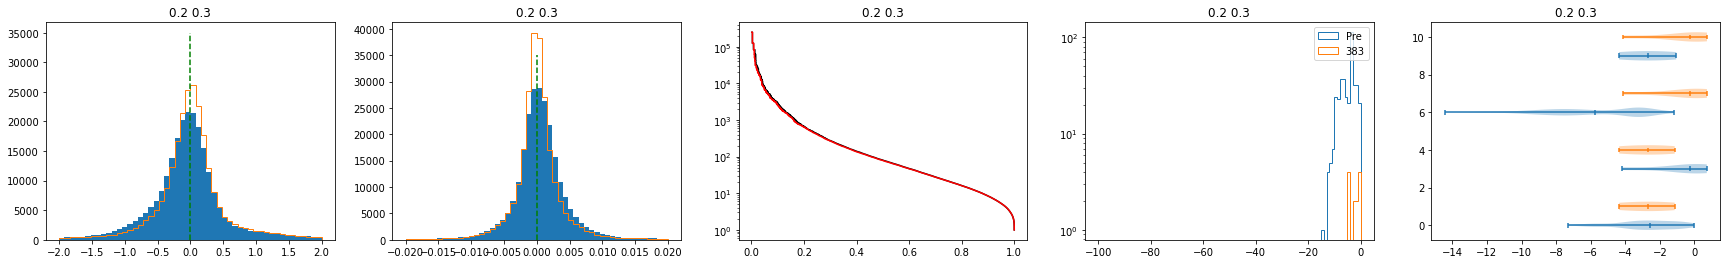

/opt/conda/envs/rapids/lib/python3.8/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.4901 - val_loss: 0.6973
Epoch 2/50
1/1 [==============================] - 0s 340ms/step - loss: 0.7856 - val_loss: 0.5522
Epoch 3/50
1/1 [==============================] - 0s 277ms/step - loss: 0.5967 - val_loss: 0.5129
Epoch 4/50
1/1 [==============================] - 0s 274ms/step - loss: 0.5393 - val_loss: 0.5647
Epoch 5/50
1/1 [==============================] - 0s 275ms/step - loss: 0.6117 - val_loss: 0.5375
Epoch 6/50
1/1 [==============================] - 0s 270ms/step - loss: 0.5738 - val_loss: 0.4868
Epoch 7/50
1/1 [==============================] - 0s 277ms/step - loss: 0.5001 - val_loss: 0.5049
Epoch 8/50
1/1 [==============================] - 0s 280ms/step - loss: 0.5325 - val_loss: 0.5250
Epoch 9/50
1/1 [==============================] - 0s 268ms/step - loss: 0.5600 - val_loss: 0.5084
Epoch 10/50
1/1 [==============================] - 0s 274ms/step - loss: 0.5347 - val_loss: 0.4829
Epoch 11/50
1/1 [=====

<ipython-input-84-5e975b39d3a8>:91: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-84-5e975b39d3a8>:92: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( ttpr, 1./tfpr, color='red' )


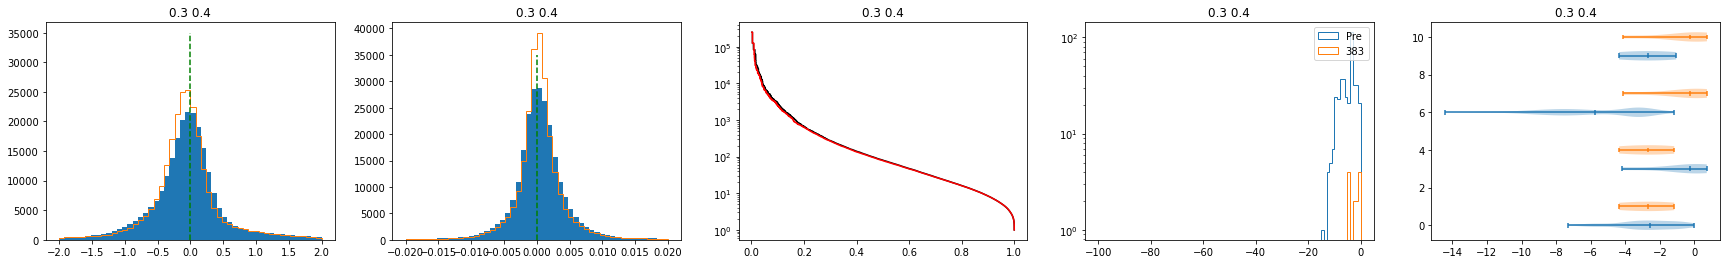

/opt/conda/envs/rapids/lib/python3.8/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.4867 - val_loss: 0.6479
Epoch 2/50
1/1 [==============================] - 0s 335ms/step - loss: 0.7334 - val_loss: 0.5117
Epoch 3/50
1/1 [==============================] - 0s 282ms/step - loss: 0.5493 - val_loss: 0.5529
Epoch 4/50
1/1 [==============================] - 0s 266ms/step - loss: 0.5852 - val_loss: 0.5820
Epoch 5/50
1/1 [==============================] - 0s 272ms/step - loss: 0.6217 - val_loss: 0.5425
Epoch 6/50
1/1 [==============================] - 0s 286ms/step - loss: 0.5649 - val_loss: 0.4971
Epoch 7/50
1/1 [==============================] - 0s 267ms/step - loss: 0.5215 - val_loss: 0.5017
Epoch 8/50
1/1 [==============================] - 0s 271ms/step - loss: 0.5343 - val_loss: 0.5185
Epoch 9/50
1/1 [==============================] - 0s 279ms/step - loss: 0.5518 - val_loss: 0.5088
Epoch 10/50
1/1 [==============================] - 0s 269ms/step - loss: 0.5301 - val_loss: 0.4948
Epoch 11/50
1/1 [=====

<ipython-input-84-5e975b39d3a8>:91: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-84-5e975b39d3a8>:92: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( ttpr, 1./tfpr, color='red' )


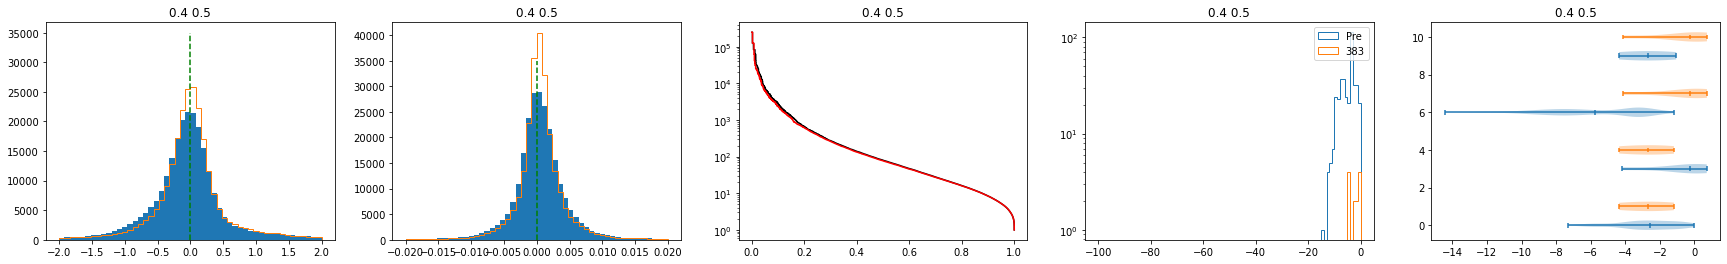

/opt/conda/envs/rapids/lib/python3.8/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.4893 - val_loss: 0.6042
Epoch 2/50
1/1 [==============================] - 0s 345ms/step - loss: 0.6760 - val_loss: 0.5286
Epoch 3/50
1/1 [==============================] - 0s 270ms/step - loss: 0.5544 - val_loss: 0.5717
Epoch 4/50
1/1 [==============================] - 0s 267ms/step - loss: 0.6062 - val_loss: 0.5554
Epoch 5/50
1/1 [==============================] - 0s 273ms/step - loss: 0.5866 - val_loss: 0.5054
Epoch 6/50
1/1 [==============================] - 0s 273ms/step - loss: 0.5403 - val_loss: 0.5006
Epoch 7/50
1/1 [==============================] - 0s 274ms/step - loss: 0.5303 - val_loss: 0.5128
Epoch 8/50
1/1 [==============================] - 0s 277ms/step - loss: 0.5391 - val_loss: 0.5025
Epoch 9/50
1/1 [==============================] - 0s 271ms/step - loss: 0.5201 - val_loss: 0.4958
Epoch 10/50
1/1 [==============================] - 0s 271ms/step - loss: 0.5254 - val_loss: 0.4840
Epoch 11/50
1/1 [=====

<ipython-input-84-5e975b39d3a8>:91: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-84-5e975b39d3a8>:92: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( ttpr, 1./tfpr, color='red' )


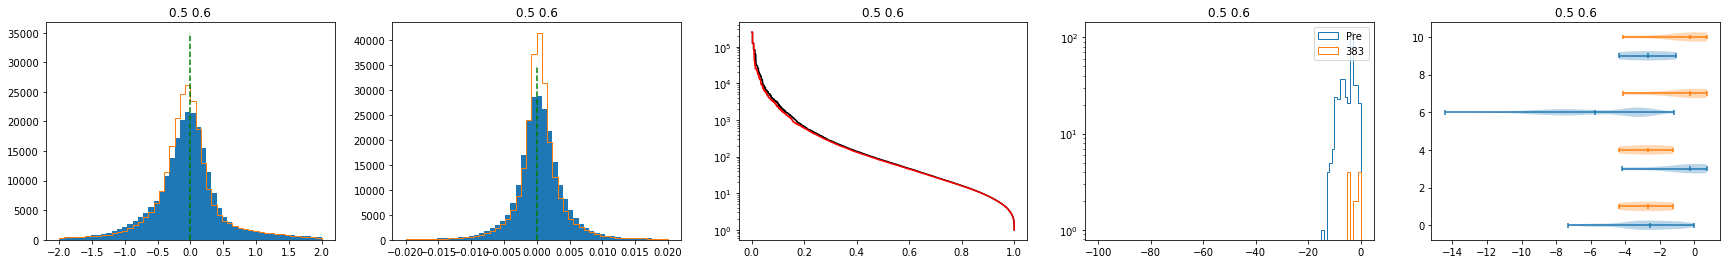

/opt/conda/envs/rapids/lib/python3.8/site-packages/keras/engine/base_layer.py:2223: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/50
1/1 [==============================] - 2s 2s/step - loss: 0.4866 - val_loss: 0.6986
Epoch 2/50
1/1 [==============================] - 0s 342ms/step - loss: 0.8011 - val_loss: 0.5336
Epoch 3/50
1/1 [==============================] - 0s 268ms/step - loss: 0.5846 - val_loss: 0.5398
Epoch 4/50
1/1 [==============================] - 0s 283ms/step - loss: 0.5630 - val_loss: 0.5935
Epoch 5/50
1/1 [==============================] - 0s 271ms/step - loss: 0.6337 - val_loss: 0.5577
Epoch 6/50
1/1 [==============================] - 0s 279ms/step - loss: 0.5838 - val_loss: 0.4894
Epoch 7/50
1/1 [==============================] - 0s 276ms/step - loss: 0.5025 - val_loss: 0.5032
Epoch 8/50
1/1 [==============================] - 0s 273ms/step - loss: 0.5432 - val_loss: 0.5314
Epoch 9/50
1/1 [==============================] - 0s 278ms/step - loss: 0.5796 - val_loss: 0.5178
Epoch 10/50
1/1 [==============================] - 0s 268ms/step - loss: 0.5576 - val_loss: 0.4889
Epoch 11/50
1/1 [=====

<ipython-input-84-5e975b39d3a8>:91: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-84-5e975b39d3a8>:92: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( ttpr, 1./tfpr, color='red' )


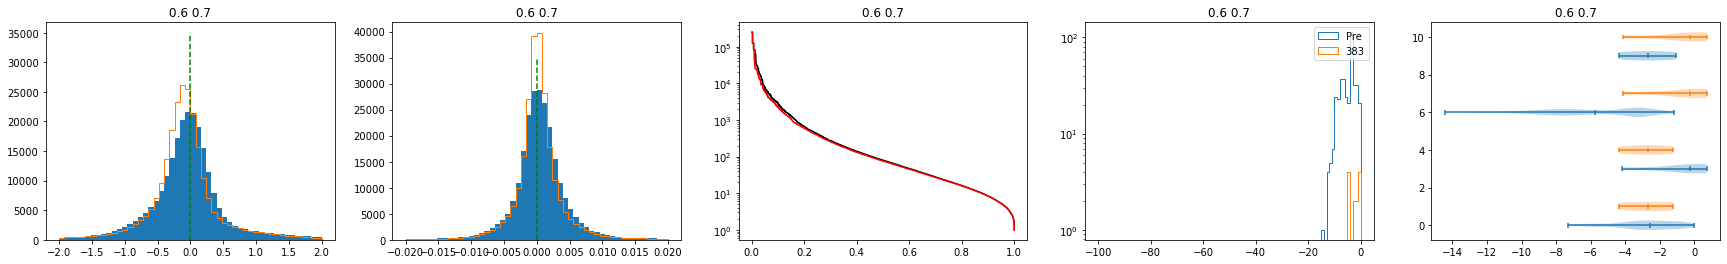

In [84]:
for jisp in initial_sparsities:
    for ifsp,fsp in enumerate(final_sparsities):
        if ifsp == 0: continue
        
        isp = final_sparsities[ifsp-1]
        
        if fsp <= isp: continue

        prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
        pruning_params = {
              'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=isp,
                                                                       final_sparsity=fsp,
                                                                       begin_step=0,
                                                                       end_step=end_step,
                                                                       frequency=100)
        }

        # pruning_params = {
        #       'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(
        #                 isp, begin_step=0, end_step=end_step, frequency=fsp)
        # }
        
        

        model_for_pruning = prune_low_magnitude(keras_model, **pruning_params)
        
        combloss = mlmodels.class_and_regr_loss(1,
                                   do_angle=1, 
                                   pen_type=0, pen_x=True, pen_a=True, bkg_pen_x=False, bkg_pen_a=False, linearized=True)

        # `prune_low_magnitude` requires a recompile.
        model_for_pruning.compile(optimizer='adam',
                      loss=combloss)

        logdir = tempfile.mkdtemp()

        callbacks = [
          tfmot.sparsity.keras.UpdatePruningStep(),
          tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
        ]

        model_for_pruning.fit(X_train, Y_train,
                          batch_size=batch_size**2, epochs=50, validation_split=validation_split,
                          callbacks=callbacks)
        
        model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
        model_for_export.save('../models_sparse/' + model_name + f'_{fsp}')
        
        pruned_weights = np.array([])
        pruned_weights_and_labels_w = []
        n_weights = 0
        for layer in model_for_export.layers:
            this_w_v = w.numpy().flatten()
            for w in layer.weights:
                pruned_weights = np.concatenate( [this_w_v, pruned_weights] )
                n_weights += w.numpy().flatten().shape[0]
                if len(w.numpy().flatten()) > 0:
                    this_w_v = np.abs(this_w_v)
                    this_w_v = this_w_v[this_w_v>0]
                    this_w_v[ this_w_v < 2**-100] = 2**-100
                    pruned_weights_and_labels_w.append( np.log2( this_w_v ) )

        pruned_preds = model_for_export.predict(X, batch_size=1024)
        pruned_yhat = sigmoid(pruned_preds[:,0])
        pruned_x_reg = pruned_preds[:,1]*mult_fact
        pruned_a_reg = pruned_preds[:,2]*mult_facta
        
        
        tmsex = metrics.mean_squared_error(  data['ev_mu_x'][this_cut], pruned_x_reg[this_cut] )
        tmsea = metrics.mean_squared_error( data['ev_mu_theta'][this_cut], pruned_a_reg[this_cut] )
        tauc = metrics.roc_auc_score( Y_mu, pruned_yhat )
        tfpr, ttpr, _ = metrics.roc_curve( Y_mu, pruned_yhat )
        print(tmsex, tmsea, tauc)
        
        pruned_mod_msex_s.append(tmsex)
        pruned_mod_msea_s.append(tmsea)
        pruned_mod_auc_s.append(tauc)
        
        ncols, nrows = (5,1)
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
        axs = axs.flatten()
        
        axs[0].hist( keras_x_reg[this_cut] - data['ev_mu_x'][this_cut], histtype='stepfilled', bins=50, range=(-2,2) )
        axs[0].hist( pruned_x_reg[this_cut] - data['ev_mu_x'][this_cut], histtype='step', bins=50, range=(-2,2) )
        axs[0].plot( [0,0], [0,35000], 'g--' )
        
        axs[1].hist( keras_a_reg[this_cut] - data['ev_mu_theta'][this_cut], histtype='stepfilled', bins=50, range=(-0.02,0.02) )
        axs[1].hist( pruned_a_reg[this_cut] - data['ev_mu_theta'][this_cut], histtype='step', bins=50, range=(-0.02,0.02) )
        axs[1].plot( [0,0], [0,35000], 'g--' )
        
        axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
        axs[2].semilogy( ttpr, 1./tfpr, color='red' )
        
        axs[3].hist( np.log2(np.abs(all_weights)), histtype='step', bins=100, range=(-100,0), label="Pre" )
        axs[3].hist( np.log2(np.abs(pruned_weights)), histtype='step', bins=100, range=(-100,0), label=f"{n_weights}" )
        axs[3].set_yscale('log')
        axs[3].legend()

        axs[4].violinplot(weights_and_labels_w, positions=3*np.array(range(len(weights_and_labels_w))), vert=False, showmedians=True)
        axs[4].violinplot(pruned_weights_and_labels_w, positions=1+3*np.array(range(len(pruned_weights_and_labels_w))), vert=False, showmedians=True)
        
        for ax in axs:
            ax.set_title(f"{isp} {fsp}")
        
        plt.show()

Pruned weights: 0
Pruned weights: 0
Pruned weights: 17
Pruned weights: 0
INFO:tensorflow:Assets written to: ../models_sparse/MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_HAND0_10/assets


<ipython-input-85-39c93f2fef8d>:42: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-85-39c93f2fef8d>:43: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( new_ttpr, 1./new_tfpr, color='red' )


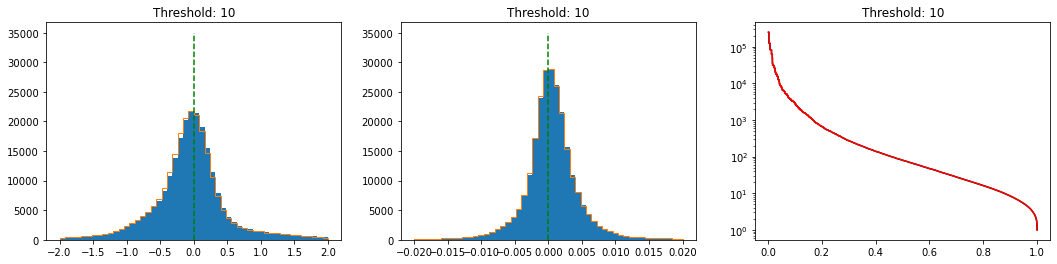

Pruned weights: 0
Pruned weights: 0
Pruned weights: 41
Pruned weights: 0
INFO:tensorflow:Assets written to: ../models_sparse/MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_HAND0_9/assets


<ipython-input-85-39c93f2fef8d>:42: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-85-39c93f2fef8d>:43: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( new_ttpr, 1./new_tfpr, color='red' )


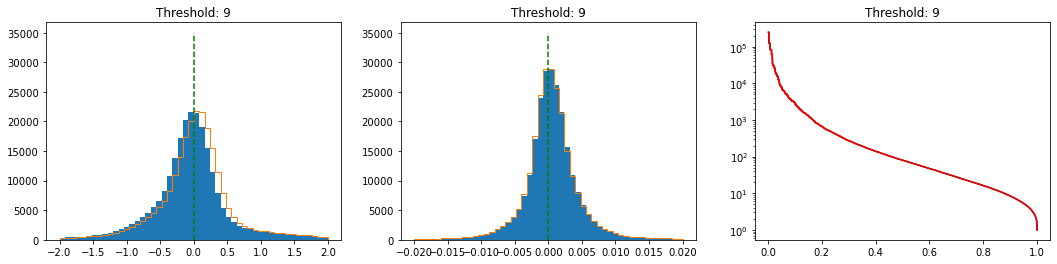

Pruned weights: 0
Pruned weights: 0
Pruned weights: 64
Pruned weights: 0
INFO:tensorflow:Assets written to: ../models_sparse/MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_HAND0_8/assets


<ipython-input-85-39c93f2fef8d>:42: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-85-39c93f2fef8d>:43: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( new_ttpr, 1./new_tfpr, color='red' )


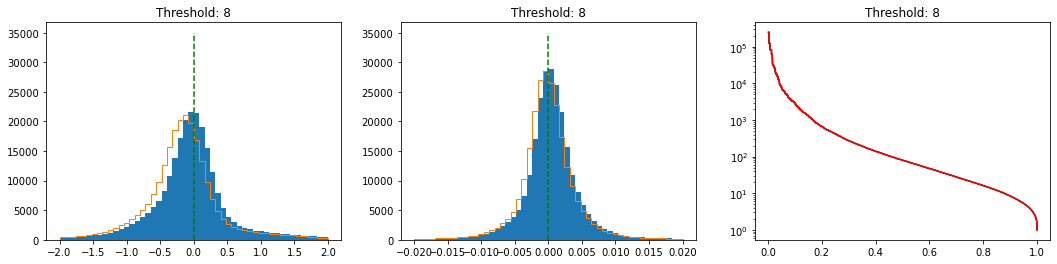

Pruned weights: 1
Pruned weights: 0
Pruned weights: 100
Pruned weights: 0
INFO:tensorflow:Assets written to: ../models_sparse/MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_HAND0_7/assets


<ipython-input-85-39c93f2fef8d>:42: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-85-39c93f2fef8d>:43: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( new_ttpr, 1./new_tfpr, color='red' )


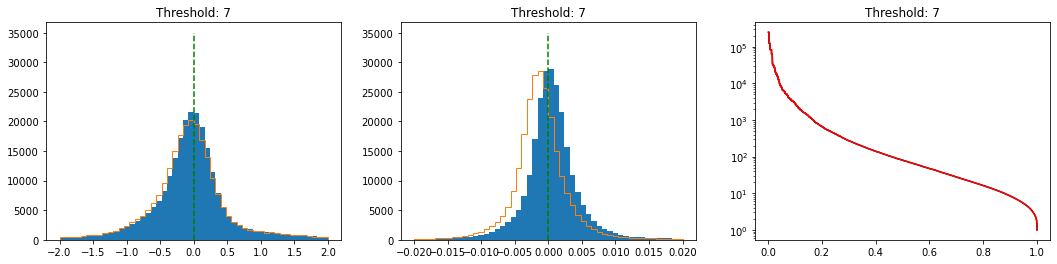

Pruned weights: 7
Pruned weights: 0
Pruned weights: 131
Pruned weights: 0
INFO:tensorflow:Assets written to: ../models_sparse/MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_HAND0_6/assets


<ipython-input-85-39c93f2fef8d>:42: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-85-39c93f2fef8d>:43: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( new_ttpr, 1./new_tfpr, color='red' )


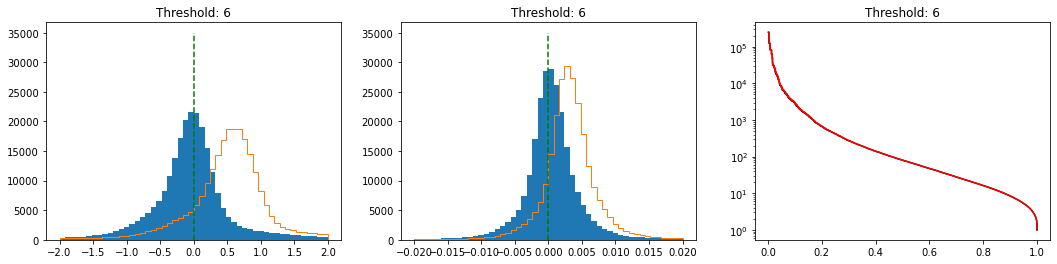

Pruned weights: 15
Pruned weights: 0
Pruned weights: 147
Pruned weights: 0
INFO:tensorflow:Assets written to: ../models_sparse/MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_HAND0_5/assets


<ipython-input-85-39c93f2fef8d>:42: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-85-39c93f2fef8d>:43: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( new_ttpr, 1./new_tfpr, color='red' )


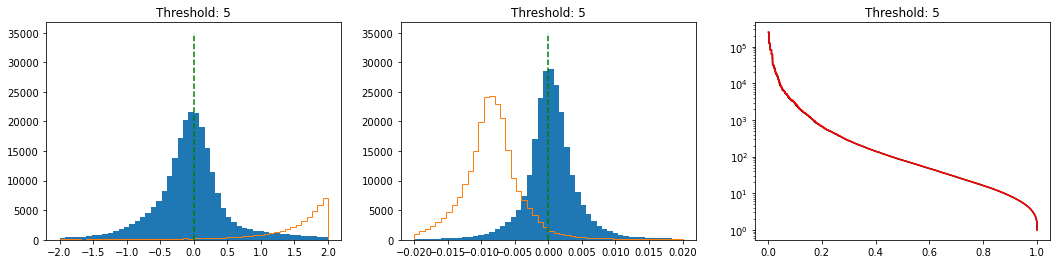

Pruned weights: 21
Pruned weights: 1
Pruned weights: 160
Pruned weights: 1
INFO:tensorflow:Assets written to: ../models_sparse/MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_HAND0_4/assets


<ipython-input-85-39c93f2fef8d>:42: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-85-39c93f2fef8d>:43: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( new_ttpr, 1./new_tfpr, color='red' )


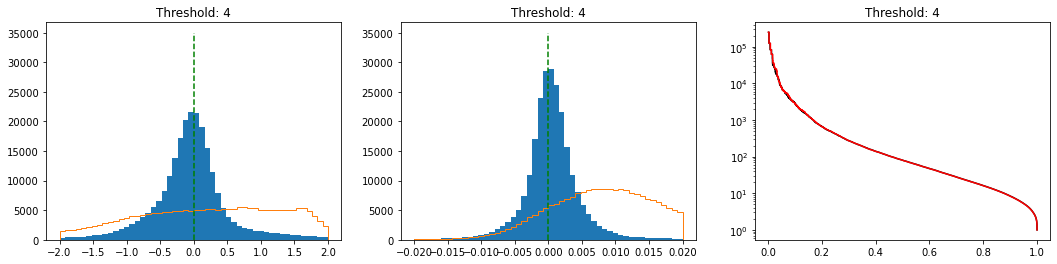

Pruned weights: 44
Pruned weights: 1
Pruned weights: 250
Pruned weights: 1
INFO:tensorflow:Assets written to: ../models_sparse/MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_HAND0_3/assets


<ipython-input-85-39c93f2fef8d>:42: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-85-39c93f2fef8d>:43: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( new_ttpr, 1./new_tfpr, color='red' )


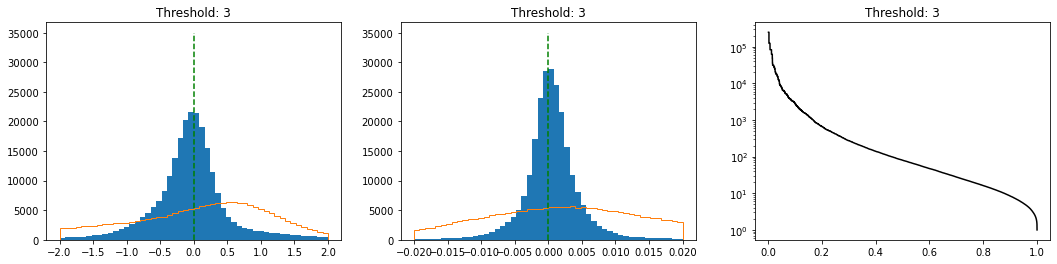

Pruned weights: 68
Pruned weights: 1
Pruned weights: 257
Pruned weights: 2
INFO:tensorflow:Assets written to: ../models_sparse/MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_HAND0_2/assets


<ipython-input-85-39c93f2fef8d>:42: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-85-39c93f2fef8d>:43: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( new_ttpr, 1./new_tfpr, color='red' )


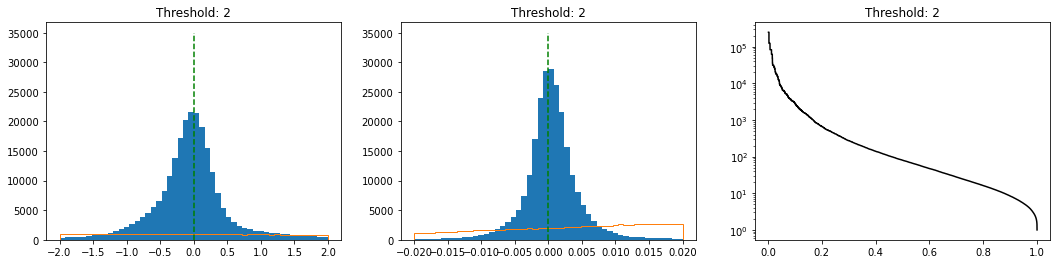

Pruned weights: 86
Pruned weights: 1
Pruned weights: 270
Pruned weights: 3
INFO:tensorflow:Assets written to: ../models_sparse/MyTCN_CL5.3.1.0..5.3.1.0_DLnone_CBNormFalse_DBNormFalse_IBNormFalse_ll1_ptype0_penXTrue_penATrue_bkgPenFalse_regBiasTrue_Flatten_DetMat_HAND0_1/assets


<ipython-input-85-39c93f2fef8d>:42: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
<ipython-input-85-39c93f2fef8d>:43: RuntimeWarning: divide by zero encountered in true_divide
  axs[2].semilogy( new_ttpr, 1./new_tfpr, color='red' )


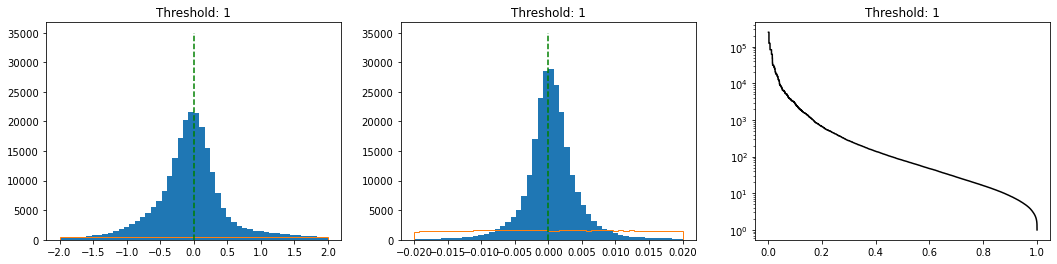

In [85]:
thrs = [10,9,8,7,6,5,4,3,2,1]
for thr in thrs:
    
    new_model = keras.models.load_model(model_loc+model_name,compile=False)
    # new_model = model_for_export#keras.models.load_model(model_loc+model_name,compile=False)

    for layer in new_model.layers:
        # if 'output' in layer.name: continue
        # print(layer)
        weights = layer.get_weights()
        for iw in range(len(weights)):
            small_weights = np.abs(weights[iw]) < 2**(-1*thr)
            print("Pruned weights:", small_weights.sum())
            weights[iw][small_weights] = 0
        layer.set_weights(weights)
    
    new_model.save('../models_sparse/' + model_name + f'_HAND0_{thr}')

    new_preds = new_model.predict(X, batch_size=1024)
    new_yhat = sigmoid(new_preds[:,0])
    new_x_reg = new_preds[:,1]*mult_fact
    new_a_reg = new_preds[:,2]*mult_facta


    tmsex = metrics.mean_squared_error(  data['ev_mu_x'][this_cut], new_x_reg[this_cut] )
    tmsea = metrics.mean_squared_error( data['ev_mu_theta'][this_cut], new_a_reg[this_cut] )
    tauc = metrics.roc_auc_score( Y_mu, new_yhat )
    new_tfpr, new_ttpr, _ = metrics.roc_curve( Y_mu, new_yhat )

    ncols, nrows = (3,1)
    fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows))
    axs = axs.flatten()

    axs[0].hist( keras_x_reg[this_cut] - data['ev_mu_x'][this_cut], histtype='stepfilled', bins=50, range=(-2,2) )
    axs[0].hist( new_x_reg[this_cut] - data['ev_mu_x'][this_cut], histtype='step', bins=50, range=(-2,2) )
    axs[0].plot( [0,0], [0,35000], 'g--' )

    axs[1].hist( keras_a_reg[this_cut] - data['ev_mu_theta'][this_cut], histtype='stepfilled', bins=50, range=(-0.02,0.02) )
    axs[1].hist( new_a_reg[this_cut] - data['ev_mu_theta'][this_cut], histtype='step', bins=50, range=(-0.02,0.02) )
    axs[1].plot( [0,0], [0,35000], 'g--' )

    axs[2].semilogy( keras_tpr, 1./keras_fpr, color='black' )
    axs[2].semilogy( new_ttpr, 1./new_tfpr, color='red' )
    
    for ax in axs:
        ax.set_title(f'Threshold: {thr}')

    plt.show()